# Objetive: Tracing the orbit of a single particle in a quasisymmetric stellarator using Near Axis and VMEC   

In [1]:
#!/usr/bin/env python3

import logging
import os
import subprocess
import time

import matplotlib.pyplot as plt
import numpy as np
from sympy import I
import vmec
from mpi4py import MPI

from neat.fields import StellnaQS, Vmec
from neat.tracing import ChargedParticle, ParticleOrbit

# Check how it changes with s_initial

In [2]:
s_initials = np.arange(0.01,0.9,0.01)
r = []
z = []
phi = []

for s_initial in s_initials:

    # Initialize an alpha particle at a radius = r_initial

    # s_initial = 0.5     # psi/psi_a for vmec
    theta_initial = np.pi   # initial poloidal angle
    phi_initial = np.pi    # initial toroidal angle
    B0 = 5              # Tesla, magnetic field on-axis
    energy = 3.52e6     # electron-volt
    charge = 2          # times charge of proton
    mass = 4            # times mass of proton
    Lambda = 0.5        # = mu * B0 / energy
    vpp_sign = -1       # initial sign of the parallel velocity, +1 or -1
    nsamples = 2        # resolution in time
    tfinal = 1e-7       # seconds
    constant_b20 =False # use a constant B20 (mean value) or the real function
    filename = "input.nearaxis"
    wout_filename = "wout_nearaxis.nc"
    
    #Generate fields
    g_field = StellnaQS.from_paper(1, B0=B0, nphi=201)
    # g_field.to_vmec(filename=filename)
    # subprocess.run(["./xvmec2000", filename])
    g_field_vmec = Vmec(wout_filename=wout_filename)

    #Generate particles
    g_particle = ChargedParticle(
        r_initial = 0.1*np.sqrt(s_initial),#s=psi/psi_a=np.sqrt(2*r_initial*psi_a/B0) bc # psi_a=(B0*0.1*0.1)/2
        theta_initial = theta_initial,
        phi_initial = phi_initial,    
        energy = energy,
        Lambda = Lambda,
        charge = charge,
        mass = mass,
        vpp_sign = vpp_sign,
    )
    g_particle_vmec = ChargedParticle(
        r_initial = s_initial,
        theta_initial = np.pi - theta_initial,     
        phi_initial = g_field.to_RZ([[0.1*np.sqrt(s_initial),theta_initial,phi_initial]])[2][0],
        energy = energy,
        Lambda = Lambda,
        charge = charge,
        mass = mass,
        vpp_sign = vpp_sign,
    )
    g_orbit = ParticleOrbit(
        g_particle, 
        g_field, 
        nsamples = nsamples, 
        tfinal = tfinal, 
        constant_b20 = constant_b20
    )

    g_orbit_vmec = ParticleOrbit(
        g_particle_vmec,
        g_field_vmec,
        nsamples = nsamples,
        tfinal = tfinal,
        constant_b20 = constant_b20,
    )

    #Calculating differences between near axis and vmec
    # print(g_orbit.rpos_cylindrical, g_orbit_vmec.rpos_cylindrical)
    diff_r = ( g_orbit.rpos_cylindrical[0] - g_orbit_vmec.rpos_cylindrical[0] \
        ) / g_orbit_vmec.rpos_cylindrical[0]
    # diff_Z = (g_orbit.rpos_cylindrical[1] - g_orbit_vmec.rpos_cylindrical[1]
    #     ) / (np.max(abs(g_orbit_vmec.rpos_cylindrical[1])))
    diff_Z = (g_orbit.rpos_cylindrical[1] - g_orbit_vmec.rpos_cylindrical[1])
    diff_phi= (
        np.unwrap(np.mod(g_orbit.rpos_cylindrical[2], 2*np.pi)) - np.unwrap(np.mod(g_orbit_vmec.rpos_cylindrical[2], 2*np.pi))
    ) / (2 * np.pi)

    r.append(abs(diff_r[0]*100))
    z.append(abs(diff_Z[0]))
    phi.append(abs(diff_phi[0]))

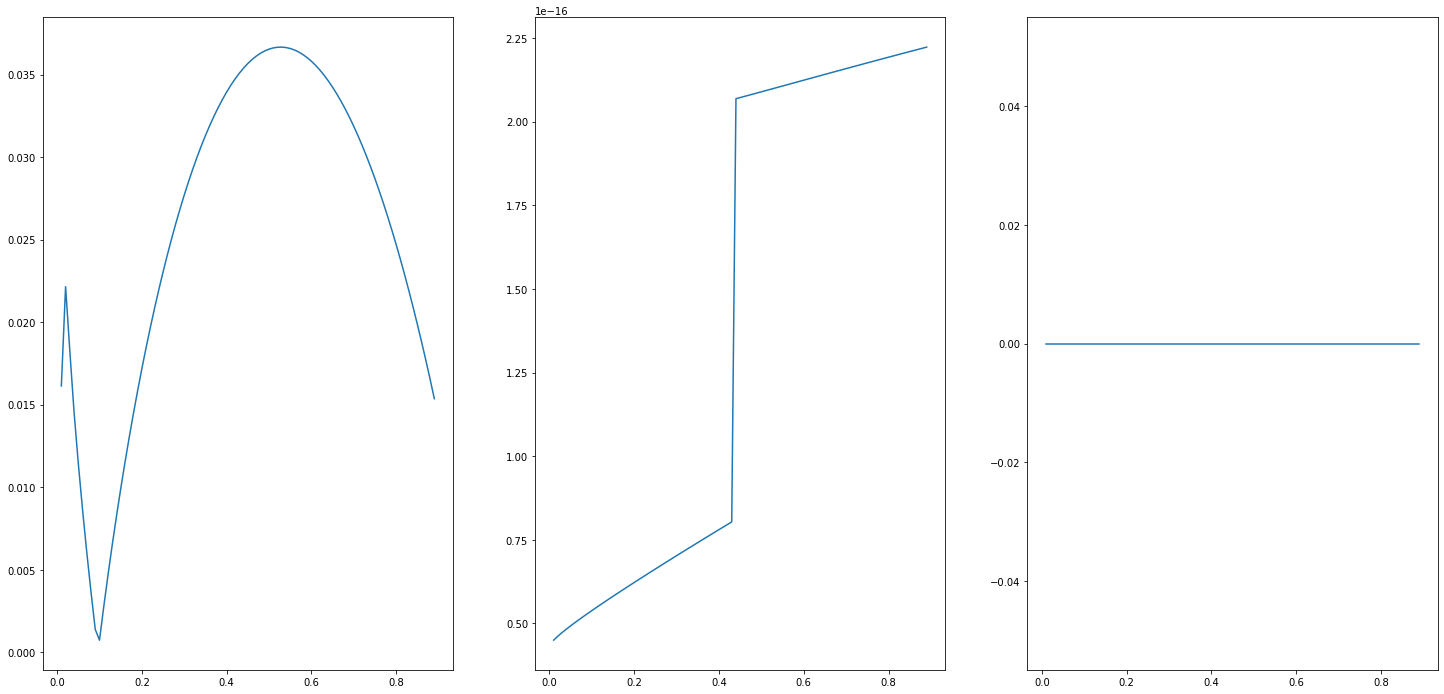

In [3]:
_ = plt.figure(figsize=(25, 12))
plt.subplot(1,3,1)
plt.plot(s_initials,r)
plt.subplot(1,3,2)
plt.plot(s_initials,z)
plt.subplot(1,3,3)
plt.plot(s_initials,phi)
plt.show()

# Check how it changes with theta_initial

In [4]:
theta_initials = np.arange(0,2*np.pi,2*np.pi/50)
r = []
z = []
phi = []

for theta_initial in theta_initials:

    # Initialize an alpha particle at a radius = r_initial

    s_initial = 0.1     # psi/psi_a for vmec
    # theta_initial = np.pi/2   # initial poloidal angle
    phi_initial = np.pi     # initial toroidal angle
    B0 = 5              # Tesla, magnetic field on-axis
    energy = 3.52e6     # electron-volt
    charge = 2          # times charge of proton
    mass = 4            # times mass of proton
    Lambda = 0.5        # = mu * B0 / energy
    vpp_sign = -1       # initial sign of the parallel velocity, +1 or -1
    nsamples = 1     # resolution in time
    tfinal = 1e-8       # seconds
    constant_b20 =False # use a constant B20 (mean value) or the real function
    filename = "input.nearaxis"
    wout_filename = "wout_nearaxis.nc"

    #Generate fields
    g_field = StellnaQS.from_paper(1, B0=B0, nphi=201)
    # g_field.to_vmec(filename=filename)
    # subprocess.run(["./xvmec2000", filename])
    g_field_vmec = Vmec(wout_filename=wout_filename)

    #Generate particles
    g_particle = ChargedParticle(
        r_initial = 0.1*np.sqrt(s_initial),#s=np.sqrt(2*r_initial*psi_a/B0) bc # psi_a=(B0*0.1*0.1)/2
        theta_initial = theta_initial,
        phi_initial = phi_initial,    
        energy = energy,
        Lambda = Lambda,
        charge = charge,
        mass = mass,
        vpp_sign = vpp_sign,
    )

    g_particle_vmec = ChargedParticle(
        r_initial = s_initial,
        theta_initial = np.pi - theta_initial,     
        phi_initial = g_field.to_RZ([[0.1*np.sqrt(s_initial),theta_initial,phi_initial]])[2][0],     
        energy = energy,
        Lambda = Lambda,
        charge = charge,
        mass = mass,
        vpp_sign = vpp_sign,
    )
    g_orbit = ParticleOrbit(
        g_particle, 
        g_field, 
        nsamples = nsamples, 
        tfinal = tfinal, 
        constant_b20 = constant_b20
    )

    g_orbit_vmec = ParticleOrbit(
        g_particle_vmec,
        g_field_vmec,
        nsamples = nsamples,
        tfinal = tfinal,
        constant_b20 = constant_b20,
    )

    #Calculating differences between near axis and vmec

    diff_r = ( g_orbit.rpos_cylindrical[0] - g_orbit_vmec.rpos_cylindrical[0] \
        ) / g_orbit_vmec.rpos_cylindrical[0]
    diff_Z = (g_orbit.rpos_cylindrical[1] - g_orbit_vmec.rpos_cylindrical[1]
        )
    # diff_Z = g_orbit.rpos_cylindrical[1] - g_orbit_vmec.rpos_cylindrical[1]
    diff_phi= (
        np.unwrap(np.mod(g_orbit.rpos_cylindrical[2], 2*np.pi)) - np.unwrap(np.mod(g_orbit_vmec.rpos_cylindrical[2], 2*np.pi))
    ) / (2 * np.pi)

    r.append(abs(diff_r[0])*100)
    z.append(abs(diff_Z[0]))
    phi.append(abs(diff_phi[0]))

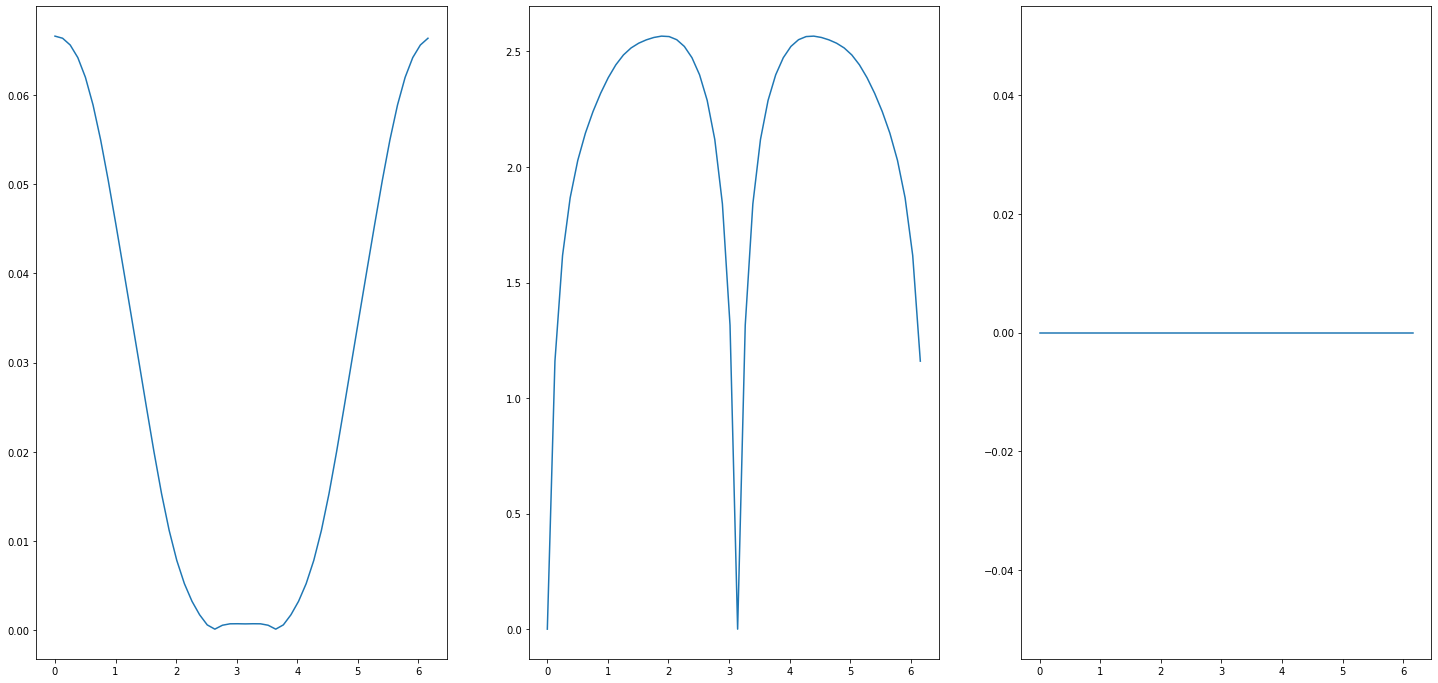

In [5]:
_ = plt.figure(figsize=(25, 12))
plt.subplot(1,3,1)
plt.plot(theta_initials,r)
plt.subplot(1,3,2)
plt.plot(theta_initials,z)
plt.subplot(1,3,3)
plt.plot(theta_initials,phi)
plt.show()

In [6]:
phi_initials = np.arange(0,2*np.pi,2*np.pi/50)
r = []
z = []
phi = []

for phi_initial in phi_initials:

    # Initialize an alpha particle at a radius = r_initial

    s_initial = 0.1     # psi/psi_a for vmec
    theta_initial = np.pi   # initial poloidal angle
    # phi_initial = np.pi     # initial toroidal angle
    B0 = 5              # Tesla, magnetic field on-axis
    energy = 3.52e6     # electron-volt
    charge = 2          # times charge of proton
    mass = 4            # times mass of proton
    Lambda = 0.5        # = mu * B0 / energy
    vpp_sign = -1       # initial sign of the parallel velocity, +1 or -1
    nsamples = 1        # resolution in time
    tfinal = 1e-8       # seconds
    constant_b20 =False # use a constant B20 (mean value) or the real function
    filename = "input.nearaxis"
    wout_filename = "wout_nearaxis.nc"

    #Generate fields
    g_field = StellnaQS.from_paper(1, B0=B0, nphi=201)
    # g_field.to_vmec(filename=filename)
    # subprocess.run(["./xvmec2000", filename])
    g_field_vmec = Vmec(wout_filename=wout_filename)

    #Generate particles
    g_particle = ChargedParticle(
        r_initial = 0.1*np.sqrt(s_initial),#s=np.sqrt(2*r_initial*psi_a/B0) bc # psi_a=(B0*0.1*0.1)/2
        theta_initial = theta_initial,
        phi_initial = phi_initial,    
        energy = energy,
        Lambda = Lambda,
        charge = charge,
        mass = mass,
        vpp_sign = vpp_sign,
    )

    g_particle_vmec = ChargedParticle(
        r_initial = s_initial,
        theta_initial = np.pi - theta_initial,     
        phi_initial = g_field.to_RZ([[0.1*np.sqrt(s_initial),theta_initial,phi_initial]])[2][0],     
        energy = energy,
        Lambda = Lambda,
        charge = charge,
        mass = mass,
        vpp_sign = vpp_sign,
    )
    g_orbit = ParticleOrbit(
        g_particle, 
        g_field, 
        nsamples = nsamples, 
        tfinal = tfinal, 
        constant_b20 = constant_b20
    )

    g_orbit_vmec = ParticleOrbit(
        g_particle_vmec,
        g_field_vmec,
        nsamples = nsamples,
        tfinal = tfinal,
        constant_b20 = constant_b20,
    )

    #Calculating differences between near axis and vmec

    diff_r = ( g_orbit.rpos_cylindrical[0] - g_orbit_vmec.rpos_cylindrical[0] \
        ) / g_orbit_vmec.rpos_cylindrical[0]
    # diff_Z = (g_orbit.rpos_cylindrical[1] - g_orbit_vmec.rpos_cylindrical[1]
    #     ) / (np.max(abs(g_orbit_vmec.rpos_cylindrical[1])))
    diff_Z = g_orbit.rpos_cylindrical[1] - g_orbit_vmec.rpos_cylindrical[1]
    diff_phi= (
        np.unwrap(np.mod(g_orbit.rpos_cylindrical[2], 2*np.pi)) - np.unwrap(np.mod(g_orbit_vmec.rpos_cylindrical[2], 2*np.pi))
    ) / (2 * np.pi)

    r.append(abs(diff_r[0]))
    z.append(abs(diff_Z[0]))
    phi.append(abs(diff_phi[0]))

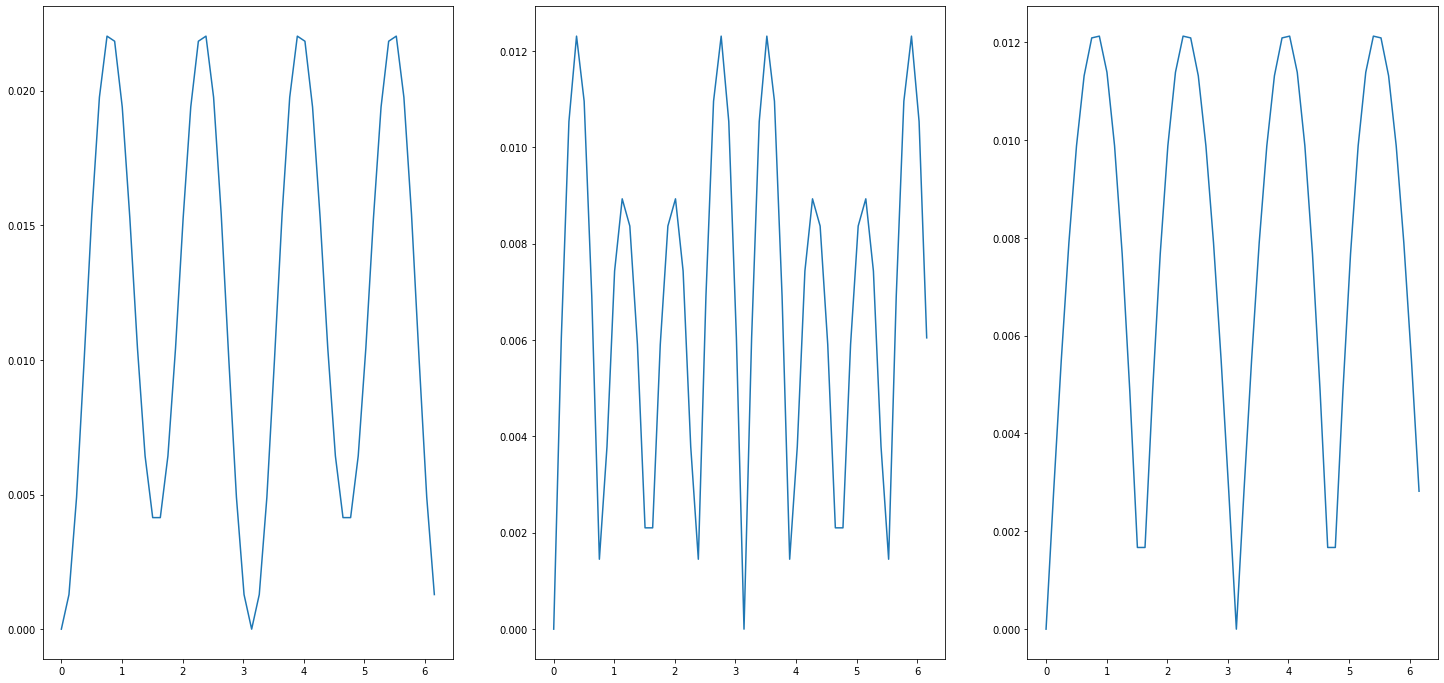

In [7]:
_ = plt.figure(figsize=(25, 12))
plt.subplot(1,3,1)
plt.plot(phi_initials,r)
plt.subplot(1,3,2)
plt.plot(phi_initials,z)
plt.subplot(1,3,3)
plt.plot(phi_initials,phi)
plt.show()